#Model for plant-disease classification 🌴

In [6]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import time
import cv2
import seaborn as sns
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dropout,Conv2D, MaxPooling2D,BatchNormalization,Dense, Activation
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model


##Preprocessing: For preprocessing the general idea here is to use dfs and not touching the original files so that we do not have to download anything again if something goes wrong and most importantly save time. 


#### The workflow goes as such:
* make a df with all filepaths for classes > n
* trim the df to remove everything greater than our max images(here 500)
* create a new augmented df while creating an augmented image and adding the path to aug_df and finally merge with the trimmed df.
* Now we will have 500 images everywhere.

#### For the split we are doing  a 80:10:10 split between train,val and test respectively

#### The image shape throughout the code is (224,224,3)

In [7]:
directory=r'---' #enter path here
min_samples=20 # set limit for minimum images a class must have to be included in the dataframe

image_paths = [] #list to store image paths     
labels=[] #list to store label

#storing all classes
classlist=os.listdir(directory)   

#checking by each label/class
for label in classlist:
    classpath=os.path.join(directory, label)#path for each label
    flist=os.listdir(classpath)#list of all image paths under a label
    
    #if number of images satisfy the min sample we add it to our lists that will be inturn added to the df
    if len(flist) >= min_samples:
        for f in flist:
            fpath=os.path.join(classpath,f)
            image_paths.append(fpath)
            labels.append(label)
    else:
        print(f'Since class {label}  has only {len(flist)} images we will omit it')


Impath=pd.Series(image_paths, name='image_paths')
lab=pd.Series(labels, name='labels')        


df=pd.concat([Impath, lab], axis=1)#Our initial df with image paths 

#Split data 
train_df, dummy_df=train_test_split(df, train_size=.8, shuffle=True, random_state=42, stratify=df['labels'])
valid_df, test_df=train_test_split(dummy_df, train_size=.5, shuffle=True, random_state=42, stratify=dummy_df['labels'])
print(f'\ntrain_df has: {len(train_df)} images,  test_df has:  {len(test_df)} images, valid_df has: {len(valid_df)} images')


#Now let us have a look how many images each class has

classes=sorted(list(train_df['labels'].unique()))
class_count = len(classes)#number of classes
print(f'\nOur initial df has: {class_count} classes')
groups=train_df.groupby('labels') #store images by labels


countlist=[]
classlist=[]

print('\n')
for label in sorted(list(train_df['labels'].unique())):
    group=groups.get_group(label)#storing all images under a label
    countlist.append(len(group))
    classlist.append(label)
    print(f'{label} has : {len(group)} images')



# To check the highest and lowest number of images
max_value=np.max(countlist)
max_index=countlist.index(max_value)
max_class=classlist[max_index]
min_value=np.min(countlist)
min_index=countlist.index(min_value)
min_class=classlist[min_index]
print(f'\n{max_class} has the highest amount of  images with {max_value} images and  {min_class} has the lowest amount of  images with  {min_value} images')

Since class tomato canker  has only 19 images we will omit it
Since class Waterlogging in plant  has only 7 images we will omit it
Since class Nitrogen deficiency in plant  has only 11 images we will omit it
Since class potassium deficiency in plant  has only 18 images we will omit it

train_df has: 53200 images,  test_df has:  6651 images, valid_df has: 6650 images

Our initial df has: 54 classes


Apple Apple scab has : 1613 images
Apple Black rot has : 1590 images
Apple Cedar apple rust has : 704 images
Apple healthy has : 1053 images
Bacterial leaf blight in rice leaf has : 32 images
Blight in corn Leaf has : 917 images
Blueberry healthy has : 962 images
Brown spot in rice leaf has : 32 images
Cercospora leaf spot has : 51 images
Cherry (including sour) Powdery mildew has : 674 images
Cherry (including_sour) healthy has : 547 images
Common Rust in corn Leaf has : 1045 images
Corn (maize) healthy has : 744 images
Garlic has : 39 images
Grape Black rot has : 3021 images
Grape Esca Bl

In [8]:
def trim(df, max_images, min_images):

  """
  This function will input a df and return a trimmed df with only x amount of max images per class

  """
  trimmed_df = pd.DataFrame(columns = df.columns)#df where we stored our trimmed image paths
  
  groups=df.groupby('labels')#store images by group
  
  
  for label in df['labels'].unique(): 
        group=groups.get_group(label)#store images in a class
        
        number_of_images=len(group) #number of images in a class
        #if images > max images then we randomly pick 'max images'   
        if number_of_images > max_images:
            s=group.sample(n=max_images, random_state=42,axis=0) #we pick x amount of random samples
            trimmed_df=pd.concat([trimmed_df, s], axis=0)#add to df
        else:
            #Now if number of images is > min images but < max images, we simply add it to the df and fill later with augmented images
            if number_of_images >=min_images:
                s=group        
                trimmed_df=pd.concat([trimmed_df, s], axis=0)#add to df
  
  
  print(f'The max images are:{max_images} and the minimum images are: {min_images}')
  return trimmed_df

In [9]:
max_images=500 # since each class has more than 200 images all classes will be trimmed to have 200 images per class
min_images=16
column='labels'
train_df= trim(train_df, max_images, min_images)

The max images are:500 and the minimum images are: 16


In [12]:
def Augment(df, n, working_dir, img_size):
  
  
  
  
  print('Initial length of dataframe is ', len(df))
    
    
  augment_dir=os.path.join(working_dir, 'aug')# directory to store augmented images
  os.mkdir(augment_dir)        
    
    
  for label in df['labels'].unique():    
      dir_path=os.path.join(augment_dir,label)    
      os.mkdir(dir_path) # make class directories within aug directory
    
    
    #counter variable for total augmented images
  total=0
  Aug_gen=ImageDataGenerator(horizontal_flip=True,  rotation_range=20, width_shift_range=.2,
                                  height_shift_range=.2, zoom_range=.2)
    
    
  groups=df.groupby('labels') # store images grouped by class
    
    
  for label in df['labels'].unique():            
      group=groups.get_group(label)  # store image paths for a particular label
      number_of_images=len(group)   # determine how many samples there are in this class        
      if number_of_images< n: # if the class has less than target number of images
            aug_img_count=0 # counter variable for number of aug images created for that class
            difference=n - number_of_images  # number of augmented images to create
            target_dir=os.path.join(augment_dir, label)  # define where to write the images
            print(f'For {label} creating {difference} augmented images. ',end='')
            #print(msg, '\r', end='') # prints over on the same line
            aug_gen=Aug_gen.flow_from_dataframe( group,  x_col='image_paths', y_col=None, target_size=img_size,
                                            class_mode=None, batch_size=1, shuffle=False, 
                                            save_to_dir=target_dir, save_prefix='aug-', color_mode='rgb',
                                            save_format='jpg')
            while aug_img_count<difference:
                images=next(aug_gen)            
                aug_img_count += len(images)
            total +=aug_img_count
  print('Total Augmented images created= ', total)
    
    
    
    # Now create an augmented df and merge it with the initial df 
    
    
    
  aug_image_paths=[]
  aug_labels=[]
  classlist=os.listdir(augment_dir)
  for label in classlist:
        classpath=os.path.join(augment_dir, label)     
        flist=os.listdir(classpath)    
        for f in flist:        
            fpath=os.path.join(classpath,f)         
            aug_image_paths.append(fpath)
            aug_labels.append(label)
  impath=pd.Series(aug_image_paths, name='image_paths')
  lab=pd.Series(aug_labels, name='labels')
  augment_df=pd.concat([impath, lab], axis=1)         
  df=pd.concat([df,augment_df], axis=0).reset_index(drop=True)
  print('Length of augmented dataframe :', len(df))
  return df

In [13]:
n=500 # number of samples in each class
working_dir=r'./' # directory to store augmented images
img_size=(224,224) # size of augmented images, we will be using this variable as a universal variable
train_df=Augment(train_df, n, working_dir, img_size)    

Initial length of dataframe is  16932
For anthracnose in tea creating 420 augmented images. Found 80 validated image filenames.
For Grape healthy creating 229 augmented images. Found 271 validated image filenames.
For potato hollow heart creating 452 augmented images. Found 48 validated image filenames.
For Tomato Tomato mosaic virus creating 202 augmented images. Found 298 validated image filenames.
For lemon canker creating 451 augmented images. Found 49 validated image filenames.
For Raspberry healthy creating 262 augmented images. Found 238 validated image filenames.
For red leaf spot in tea creating 386 augmented images. Found 114 validated image filenames.
For Strawberry healthy creating 208 augmented images. Found 292 validated image filenames.
For corn crop creating 417 augmented images. Found 83 validated image filenames.
For Gray Leaf Spot in corn Leaf creating 41 augmented images. Found 459 validated image filenames.
For Potato healthy creating 402 augmented images. Found 98

### Now to load our datasets, we will be using image data generator.

In [14]:
batch_size=32 


traingen0=ImageDataGenerator(horizontal_flip=True,rotation_range=20, width_shift_range=.2,
                                  height_shift_range=.2, zoom_range=.2 )


test_and_val_gen=ImageDataGenerator()


train_gen=traingen0.flow_from_dataframe(train_df, x_col='image_paths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)



valid_gen=test_and_val_gen.flow_from_dataframe(valid_df, x_col='image_paths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)



#To determine the batch size for test_gen so we can check each image and nit miss out anything

length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/test_batch_size)



test_gen=test_and_val_gen.flow_from_dataframe(test_df, x_col='image_paths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)



classes=list(train_gen.class_indices.keys())
class_indices=list(train_gen.class_indices.values())
class_count=len(classes)
labels=test_gen.labels
print ('test batch size: ' ,test_batch_size, '  test steps: ', test_steps, ' number of classes : ', class_count)

Found 27000 validated image filenames belonging to 54 classes.
Found 6650 validated image filenames belonging to 54 classes.
Found 6651 validated image filenames belonging to 54 classes.
test batch size:  9   test steps:  739  number of classes :  54


#Now for our model, we use transfer learning with EfficientNetB3 as our base model with Imagenet as its weights and adamax as its optimizer. Trainable is left true

In [30]:

img_shape=(224,224, 3)


base_model=tf.keras.applications.efficientnet.EfficientNetB5(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 

base_model.trainable=True

x=base_model.output

x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)

x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)

x=Dropout(rate=.4, seed=42)(x)       

output=Dense(class_count, activation='softmax')(x)

model=Model(inputs=base_model.input, outputs=output)

lr=.001 # We can change this lr, after x epochs one can try lowering it
model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy']) 

115263384/115263384 [==============================] - 2s 0us/step


In [29]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 224, 224, 3)  7          ['rescaling_1[0][0]']            
 )                                                                                                
                                                                                            

#This is a user input callback that I found on kaggle. Every x epoch it will ask the user if they want to continue and also change the lr.

In [31]:
class LR_ASK(keras.callbacks.Callback):
    def __init__ (self, model, epochs,  ask_epoch): 
        super(LR_ASK, self).__init__()
        self.model=model               
        self.ask_epoch=ask_epoch
        self.epochs=epochs
        self.ask=True # This is the boolean to use to ask the user to continue or not
        self.lowest_vloss=np.inf
        self.best_weights=self.model.get_weights() # set best weights to model's initial weights
        self.best_epoch=1
        
       #When training begins 
    def on_train_begin(self, logs=None):
        if self.ask_epoch == 0: 
            print('you set ask_epoch = 0, ask_epoch will be set to 1', flush=True)
            self.ask_epoch=1
        if self.ask_epoch >= self.epochs: 
            print('ask_epoch >= epochs, will train for ', epochs, ' epochs', flush=True)
            self.ask=False 
        if self.epochs == 1:
            self.ask=False 
        else:
            print('Training will proceed until epoch:', ask_epoch,' then you will be asked to') 
            print(' enter H or 0 to halt training or enter a positive integer for how many more epochs to run the model before being asked again')  
        self.start_time= time.time() # storing time at which training started

    #This runs when training ends    
    def on_train_end(self, logs=None):    
        print('loading model with weights from epoch ', self.best_epoch)
        self.model.set_weights(self.best_weights) # get best weights
        tr_duration=time.time() - self.start_time   # check how long the training lasted       
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print (msg, flush=True) # print out training time

     #this method runs at the end of epoch   
    def on_epoch_end(self, epoch, logs=None): 
        v_loss=logs.get('val_loss')  #validation loss for this epoch
        if v_loss< self.lowest_vloss: #check if it is the lowest loss
            self.lowest_vloss=v_loss
            self.best_weights=self.model.get_weights() # store the best weights
            self.best_epoch=epoch + 1
            print (f'\n validation loss of {v_loss:7.4f} is below lowest loss, saving weights from epoch {str(epoch + 1):3s} as best weights')
        else:
            print (f'\n validation loss of {v_loss:7.4f} is above lowest loss of {self.lowest_vloss:7.4f} keeping weights from epoch {str(self.best_epoch)} as best weights')
        
        if self.ask: # If true we ask the user if they wanto to halt/continue/change lr
            if epoch + 1 ==self.ask_epoch: # check if it is the correct epoch to ask?
                print('\n Enter H or 0 to end training or  a positive  integer for the number of additional epochs to run the model before being asked again')
                ans=input()
                
                if ans == 'H' or ans =='h' or ans == '0': # quit training for these inputs
                    print ('you entered ', ans, ' Training halted on epoch ', epoch+1, ' due to user input\n', flush=True)
                    self.model.stop_training = True # stop training
                else: # if user wants to continue(for x amount of epochs)
                    self.ask_epoch += int(ans)
                    if self.ask_epoch > self.epochs:#if epochs mentioned are more than initial value
                        print('\nYou specified maximum epochs of as ', self.epochs, ' cannot train for ', self.ask_epoch, flush =True)
                    else:#continue to train 
                        print ('you entered ', ans, ' Training will continue to epoch ', self.ask_epoch, flush=True)
                        lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) #current learning rate
                        print(f'current LR is  {lr:7.5f}  hit enter to keep  this LR or enter a new LR')#ask if we want a new lr
                        ans=input(' ')
                        if ans =='':
                            print (f'keeping current LR of {lr:7.5f}')
                        else:
                            new_lr=float(ans)
                            tf.keras.backend.set_value(self.model.optimizer.lr, new_lr) # set the learning rate in the optimizer
                            print(' changing LR to ', ans)

##Now let us run the code

In [32]:
epochs=20
ask_epoch=5
ask=LR_ASK(model, epochs,  ask_epoch)
callbacks=[ask]

In [33]:
history=model.fit(x=train_gen,  epochs=epochs, verbose=1, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

Training will proceed until epoch: 5  then you will be asked to
 enter H or 0 to halt training or enter a positive integer for how many more epochs to run the model before being asked again
Epoch 1/20
844/844 [==============================] - ETA: 0s - loss: 4.5720 - accuracy: 0.8292
 validation loss of  1.4580 is below lowest loss, saving weights from epoch 1   as best weights
844/844 [==============================] - 991s 1s/step - loss: 4.5720 - accuracy: 0.8292 - val_loss: 1.4580 - val_accuracy: 0.9710
Epoch 2/20
844/844 [==============================] - ETA: 0s - loss: 0.9437 - accuracy: 0.9664
 validation loss of  0.5664 is below lowest loss, saving weights from epoch 2   as best weights
844/844 [==============================] - 960s 1s/step - loss: 0.9437 - accuracy: 0.9664 - val_loss: 0.5664 - val_accuracy: 0.9841
Epoch 3/20
844/844 [==============================] - ETA: 0s - loss: 0.5735 - accuracy: 0.9782
 validation loss of  0.4600 is below lowest loss, saving weights f

### Let us plot the graph for training and validation curves


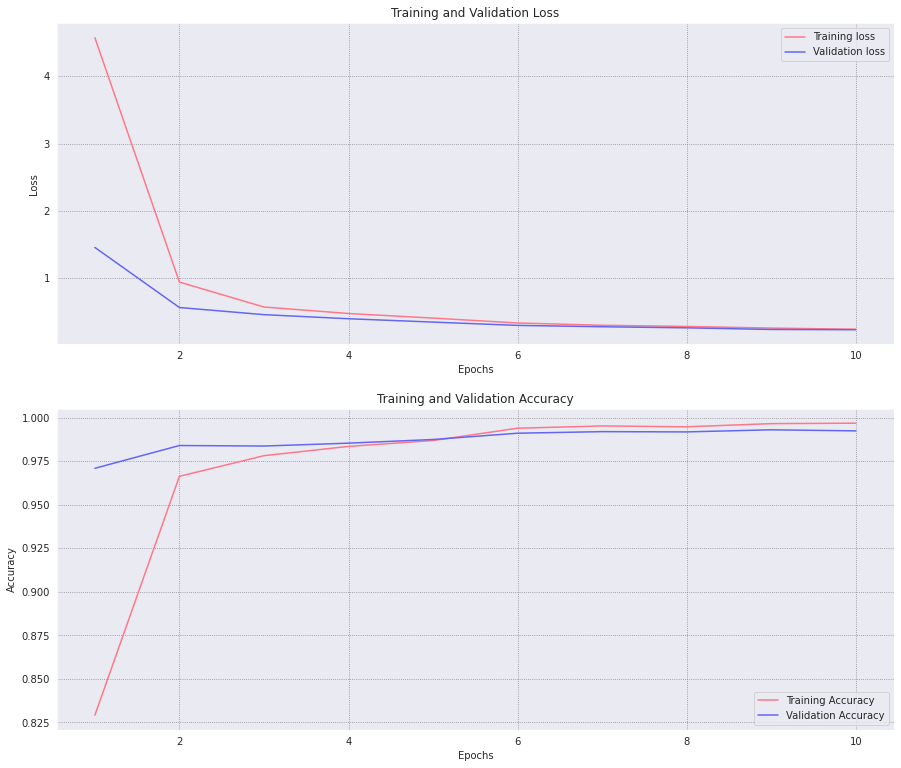

In [34]:
    sns.set_style("darkgrid", {"grid.color": ".5", "grid.linestyle": ":"})
    
    training_acc =history.history['accuracy']
    training_loss=history.history['loss']
    val_acc=history.history['val_accuracy']
    val_loss=history.history['val_loss']
    
    
    Epoch_count=len(training_acc)
    Epochs=[]
    
    
    for i in range (0 ,Epoch_count):
        Epochs.append(i+1)   
    
    
    fig,axes=plt.subplots(nrows=2, ncols=1, figsize=(15,13))
    axes[0].plot(Epochs,training_loss, '#ff7788', label='Training loss')
    axes[0].plot(Epochs,val_loss,'#6366f1',label='Validation loss' )
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    
    axes[1].plot (Epochs,training_acc,'#ff7788',label= 'Training Accuracy')
    axes[1].plot (Epochs,val_acc,'#6366f1',label= 'Validation Accuracy')
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend() 
    plt.show()

###To evaluate  we use classification report from sklearn. We can make a confusion matrix as well but that might make it a tad convulated

In [35]:

y_pred= []#store predictions
y_true=test_gen.labels
classes=list(test_gen.class_indices.keys())
class_count=len(classes)
errors=0 #store errors
preds=model.predict(test_gen, verbose=1)
    
tests=len(preds)    
    
#loop to check the number of errors    
for i, j in enumerate(preds):        
    pred_index=np.argmax(j)         
    true_index=test_gen.labels[i]      
    if pred_index != true_index: # is predicted label=true label?                                           
        errors=errors + 1
    y_pred.append(pred_index)
            
acc=(1-(errors/tests))* 100 
print(f'Model made {errors} errors out  {tests} images. Accuracy = {acc:6.2f}%')
    
    
ypred=np.array(y_pred)
ytrue=np.array(y_true)
    
report = classification_report(y_true, y_pred, target_names=classes, digits= 4) # storeclassification report
print("\nClassification Report:\n", report)

739/739 [==============================] - 58s 73ms/step
Model made 42 errors out  6651 images. Accuracy =  99.37%

Classification Report:
                                              precision    recall  f1-score   support

                           Apple Apple scab     1.0000    1.0000    1.0000       202
                            Apple Black rot     1.0000    0.9950    0.9975       199
                     Apple Cedar apple rust     1.0000    1.0000    1.0000        88
                              Apple healthy     0.9925    1.0000    0.9962       132
         Bacterial leaf blight in rice leaf     1.0000    1.0000    1.0000         4
                        Blight in corn Leaf     0.9268    0.9913    0.9580       115
                          Blueberry healthy     1.0000    0.9917    0.9958       120
                    Brown spot in rice leaf     1.0000    1.0000    1.0000         4
                       Cercospora leaf spot     1.0000    0.5000    0.6667         6
     Cher

In [36]:
from tensorflow.keras.models import save_model,load_model


In [25]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [37]:
save_model(model,'/content/drive/MyDrive/Models/plantdisease500-B5.h5')

#To summarize:
The model overall gives us 98% accuracy with only 5 epochs for 54 classes
This can be improved further with more epochs and a lower learning rate. One can also experiment with other optimizers and models like Xception,resnet etc for better results.